In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/daibetes-detection/diabetes prediction/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [4]:
#infromation of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


In [5]:
#any null values 
#not neccessary in above information we can see
df.isnull().values.any()

False

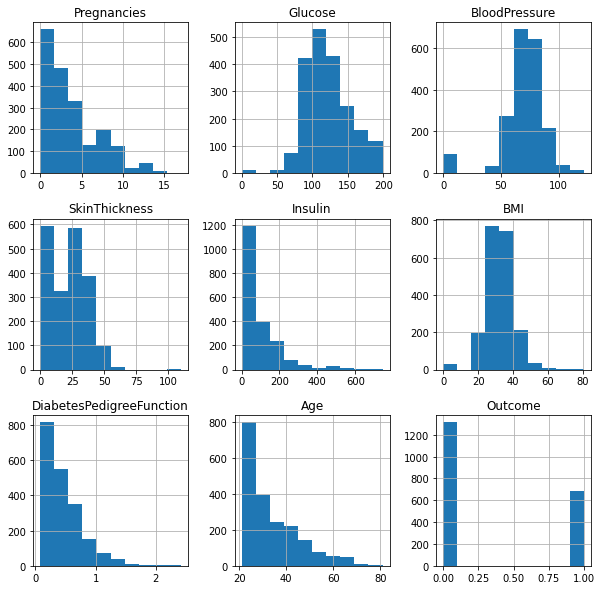

In [6]:
#histogram
df.hist(bins=10,figsize=(10,10))
plt.show()

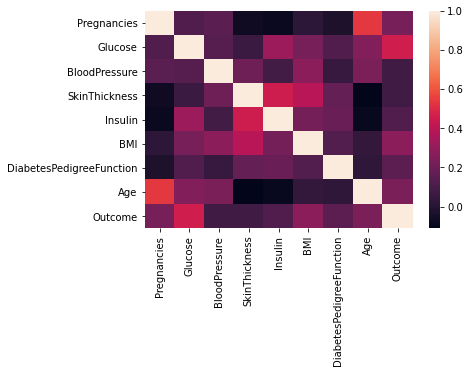

In [7]:
#correlation

sns.heatmap(df.corr())
# we can see skin thickness,insulin,pregnencies and age are full independent to each other
#age and pregencies has negative correlation

In [8]:
df.corr().T

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.120405,0.149672,-0.063375,-0.076600,0.019475,-0.025453,0.539457,0.224437
Glucose,0.120405,1.000000,0.138044,0.062368,0.320371,0.226864,0.123243,0.254496,0.458421
BloodPressure,0.149672,0.138044,1.000000,0.198800,0.087384,0.281545,0.051331,0.238375,0.075958
SkinThickness,-0.063375,0.062368,0.198800,1.000000,0.448859,0.393760,0.178299,-0.111034,0.076040
Insulin,-0.076600,0.320371,0.087384,0.448859,1.000000,0.223012,0.192719,-0.085879,0.120924
BMI,0.019475,0.226864,0.281545,0.393760,0.223012,1.000000,0.125719,0.038987,0.276726
DiabetesPedigreeFunction,-0.025453,0.123243,0.051331,0.178299,0.192719,0.125719,1.000000,0.026569,0.155459
Age,0.539457,0.254496,0.238375,-0.111034,-0.085879,0.038987,0.026569,1.000000,0.236509
Outcome,0.224437,0.458421,0.075958,0.076040,0.120924,0.276726,0.155459,0.236509,1.000000


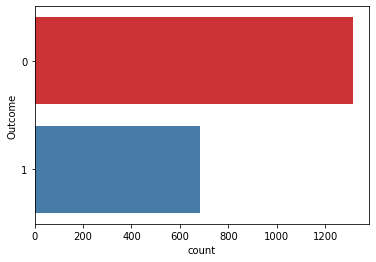

In [9]:
#lets count total outcome in each target 0 1
#0 means no diabeted
#1 means patient with diabtes
sns.countplot(y=df['Outcome'],palette='Set1')

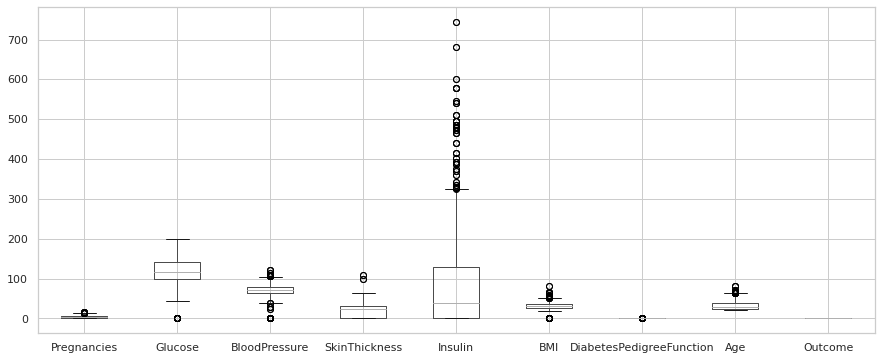

In [10]:
#box plot for outlier visualization
sns.set(style="whitegrid")
df.boxplot(figsize=(15,6))

In [11]:
#outlier remove

Q1=df.quantile(0.25)
Q3=df.quantile(0.75)
IQR=Q3-Q1
print("---Q1--- \n",Q1)
print("\n---Q3--- \n",Q3)
print("\n---IQR---\n",IQR)

#print((df < (Q1 - 1.5 * IQR))|(df > (Q3 + 1.5 * IQR)))


---Q1--- 
 Pregnancies                  1.000
Glucose                     99.000
BloodPressure               63.500
SkinThickness                0.000
Insulin                      0.000
BMI                         27.375
DiabetesPedigreeFunction     0.244
Age                         24.000
Outcome                      0.000
Name: 0.25, dtype: float64

---Q3--- 
 Pregnancies                   6.000
Glucose                     141.000
BloodPressure                80.000
SkinThickness                32.000
Insulin                     130.000
BMI                          36.800
DiabetesPedigreeFunction      0.624
Age                          40.000
Outcome                       1.000
Name: 0.75, dtype: float64

---IQR---
 Pregnancies                   5.000
Glucose                      42.000
BloodPressure                16.500
SkinThickness                32.000
Insulin                     130.000
BMI                           9.425
DiabetesPedigreeFunction      0.380
Age                 

In [12]:
#outlier remove
df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape,df_out.shape
#more than 80 records deleted

((2000, 9), (1652, 9))

In [25]:
#lets extract features and targets
y=df_out['Outcome']
X=df_out.drop(columns=['Outcome'])

In [26]:
#Splitting train test data 80 20 ratio
from sklearn.model_selection import train_test_split
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.2)

In [15]:
train_X.shape,test_X.shape,train_y.shape,test_y.shape

((1321, 8), (331, 8), (1321,), (331,))

In [27]:
from sklearn.metrics import confusion_matrix,accuracy_score,make_scorer
from sklearn.model_selection import cross_validate

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

#cross validation purpose
scoring = {'accuracy': make_scorer(accuracy_score),'prec': 'precision'}
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn)}

def display_result(result):
    print("TP: ",result['test_tp'])
    print("TN: ",result['test_tn'])
    print("FN: ",result['test_fn'])
    print("FP: ",result['test_fp'])

In [35]:
#Lets build the model

#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

acc=[]
roc=[]

clf=LogisticRegression()
clf.fit(train_X,train_y)
y_pred=clf.predict(test_X)
#find accuracy
ac=accuracy_score(test_y,y_pred)
acc.append(ac)

#find the ROC_AOC curve
rc=roc_auc_score(test_y,y_pred)
roc.append(rc)
print("\nAccuracy {0} ROC {1}".format(ac,rc))

#cross val score
result=cross_validate(clf,train_X,train_y,scoring=scoring,cv=10)
display_result(result)

#display predicted values uncomment below line
#pd.DataFrame(data={'Actual':test_y,'Predicted':y_pred}).head()


Accuracy 0.7885196374622356 ROC 0.73083790068095
TP:  [21 12 17 21 24 25 20 18 27 24]
TN:  [83 81 84 85 85 78 85 81 84 87]
FN:  [20 28 23 20 17 16 21 23 14 17]
FP:  [ 9 11  8  6  6 13  6 10  7  4]


In [36]:
#Support Vector Machine
from sklearn.svm import SVC

clf=SVC(kernel='linear')
clf.fit(train_X,train_y)
y_pred=clf.predict(test_X)
#find accuracy
ac=accuracy_score(test_y,y_pred)
acc.append(ac)

#find the ROC_AOC curve
rc=roc_auc_score(test_y,y_pred)
roc.append(rc)
print("\nAccuracy {0} ROC {1}".format(ac,rc))

#cross val score
result=cross_validate(clf,train_X,train_y,scoring=scoring,cv=10)
display_result(result)

#display predicted values uncomment below line
#pd.DataFrame(data={'Actual':test_y,'Predicted':y_pred}).head()


Accuracy 0.7945619335347432 ROC 0.7353222056136853
TP:  [21 12 19 21 25 25 20 18 26 24]
TN:  [83 81 84 85 84 74 85 85 83 86]
FN:  [20 28 21 20 16 16 21 23 15 17]
FP:  [ 9 11  8  6  7 17  6  6  8  5]


In [37]:
#KNN

from sklearn.neighbors import KNeighborsClassifier

clf=KNeighborsClassifier(n_neighbors=3)
clf.fit(train_X,train_y)
y_pred=clf.predict(test_X)
#find accuracy
ac=accuracy_score(test_y,y_pred)
acc.append(ac)

#find the ROC_AOC curve
rc=roc_auc_score(test_y,y_pred)
roc.append(rc)
print("\nAccuracy {0} ROC {1}".format(ac,rc))

#cross val score
result=cross_validate(clf,train_X,train_y,scoring=scoring,cv=10)
display_result(result)

#display predicted values uncomment below line
#pd.DataFrame(data={'Actual':test_y,'Predicted':y_pred}).head()


Accuracy 0.8942598187311178 ROC 0.8690001660853679
TP:  [29 30 24 30 32 36 30 31 34 34]
TN:  [84 82 82 80 83 82 85 77 83 84]
FN:  [12 10 16 11  9  5 11 10  7  7]
FP:  [ 8 10 10 11  8  9  6 14  8  7]


In [31]:
#Random forest
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier()
clf.fit(train_X,train_y)

y_pred=clf.predict(test_X)
#find accuracy
ac=accuracy_score(test_y,y_pred)
acc.append(ac)

#find the ROC_AOC curve
rc=roc_auc_score(test_y,y_pred)
roc.append(rc)
print("\nAccuracy {0} ROC {1}".format(ac,rc))

#cross val score
result=cross_validate(clf,train_X,train_y,scoring=scoring,cv=10)
display_result(result)

#display predicted values uncomment below line
#pd.DataFrame(data={'Actual':test_y,'Predicted':y_pred}).head()


Accuracy 0.9848942598187311 ROC 0.9887892376681615
TP:  [32 35 33 39 37 39 40 36 41 41]
TN:  [92 92 91 88 90 86 91 87 90 91]
FN:  [9 5 7 2 4 2 1 5 0 0]
FP:  [0 0 1 3 1 5 0 4 1 0]


In [32]:
#Naive Bayes Theorem
#import library
from sklearn.naive_bayes import GaussianNB

clf=GaussianNB()
clf.fit(train_X,train_y)
y_pred=clf.predict(test_X)
#find accuracy
ac=accuracy_score(test_y,y_pred)
acc.append(ac)

#find the ROC_AOC curve
rc=roc_auc_score(test_y,y_pred)
roc.append(rc)
print("\nAccuracy {0} ROC {1}".format(ac,rc))

#cross val score
result=cross_validate(clf,train_X,train_y,scoring=scoring,cv=10)
display_result(result)

#display predicted values uncomment below line
#pd.DataFrame(data={'Actual':test_y,'Predicted':y_pred}).head()


Accuracy 0.7854984894259819 ROC 0.7500830426839395
TP:  [23 15 21 23 30 24 24 24 29 29]
TN:  [78 69 81 79 80 67 81 76 77 79]
FN:  [18 25 19 18 11 17 17 17 12 12]
FP:  [14 23 11 12 11 24 10 15 14 12]


In [33]:
#Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
clf=GradientBoostingClassifier(n_estimators=50,learning_rate=0.2)
clf.fit(train_X,train_y)
y_pred=clf.predict(test_X)
#find accuracy
ac=accuracy_score(test_y,y_pred)
acc.append(ac)

#find the ROC_AOC curve
rc=roc_auc_score(test_y,y_pred)
roc.append(rc)
print("\nAccuracy {0} ROC {1}".format(ac,rc))

#cross val score
result=cross_validate(clf,train_X,train_y,scoring=scoring,cv=10)
display_result(result)

#display predicted values uncomment below line
#pd.DataFrame(data={'Actual':test_y,'Predicted':y_pred}).head()


Accuracy 0.8851963746223565 ROC 0.859886231523003
TP:  [27 20 24 28 32 34 33 23 32 36]
TN:  [90 89 88 85 86 80 90 82 85 89]
FN:  [14 20 16 13  9  7  8 18  9  5]
FP:  [ 2  3  4  6  5 11  1  9  6  2]


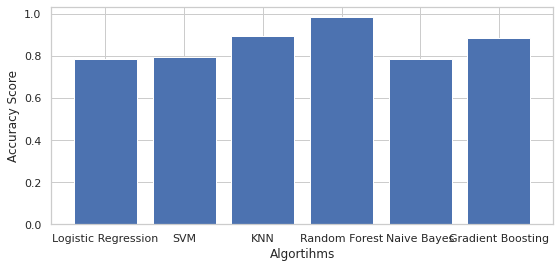

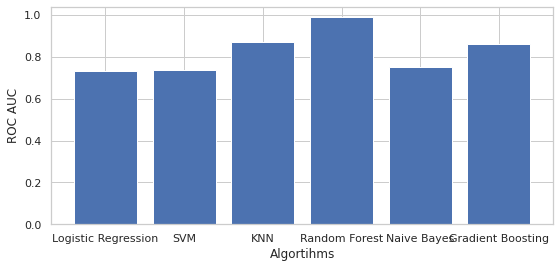

In [34]:
#lets plot the bar graph

ax=plt.figure(figsize=(9,4))
plt.bar(['Logistic Regression','SVM','KNN','Random Forest','Naive Bayes','Gradient Boosting'],acc,label='Accuracy')
plt.ylabel('Accuracy Score')
plt.xlabel('Algortihms')
plt.show()

ax=plt.figure(figsize=(9,4))
plt.bar(['Logistic Regression','SVM','KNN','Random Forest','Naive Bayes','Gradient Boosting'],roc,label='ROC AUC')
plt.ylabel('ROC AUC')
plt.xlabel('Algortihms')
plt.show()